This notebook is taken from Nihat Oguz work

In [1]:
from phoenix import potentials, distribution_functions, actions_to_phase_space, sampling
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

We now use our sampling pipeline to generate candidate actions from the total DF.

In [2]:
#define parameters
params_previous = {
    "R0": 8.0,
    "Rd": 2.5,
    "v0": 220.0,
    "L0": 50.0,
    "sigma_r0": 40.0,
    "sigma_z0": 20.0,
    "tau_m": 10.0,
    "tau1": 0.1,
    "beta": 0.33,
    "t0": 8.0,
    "n_age_bins": 10.0,
    "Rd_thick": 2.3,
    "L0_thick": 50.0,
    "sigma_r0_thick": 60.0,
    "sigma_z0_thick": 32.0,
    "frac_thick": 0.2,
    "Z_max": 0.03,
    "Z_min": 0.005,
}

envelope_max = 3.0
n_candidates = 500_000
key = jax.random.PRNGKey(42)

In [ ]:
#define parameters
params = {
    "R0": 8.0,
    "Rd": 2.5,
    #"v0": 220.0,
    "L0": 50.0,
    "sigma_r0": 40.0,
    "sigma_z0": 20.0,
    "tau_m": 10.0,
    "tau1": 0.1,
    "beta": 0.33,
    "t0": 8.0,
    #"n_age_bins": 10.0,
    "Rd_thick": 2.3,
    "L0_thick": 50.0,
    "sigma_r0_thick": 60.0,
    "sigma_z0_thick": 32.0,
    "frac_thick": 0.2,
    "Z_max": 0.03,
    "Z_min": 0.005,
}

envelope_max = 3.0
n_candidates = 100
key = jax.random.PRNGKey(42)

In [4]:
from phoenix.sampling import sample_df_potential
from phoenix.actions_to_phase_space import map_actions_to_phase_space
from phoenix.distribution_functions import assign_age_and_metallicity

def forward_model(key, params, n_candidates=n_candidates, envelope_max=envelope_max):
    #Sample actions from the distribution function
    #Generate candidate actions
    samples, soft_weights = sample_df_potential(key, params, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = map_actions_to_phase_space(samples, params, key)
    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]
    v_x = phase_space_coords[:, 3]
    v_y = phase_space_coords[:, 4]
    v_z = phase_space_coords[:, 5]
    
    n_samples = phase_space_coords.shape[0]
    key, subkey = jax.random.split(key)
    ages, metallicities = assign_age_and_metallicity(subkey, n_samples, params)

    return x, y, z, v_x, v_y, v_z, ages, metallicities

In [5]:
x, y, z, v_x, v_y, v_z, ages, metallicities = forward_model(key, params, n_candidates, envelope_max)

In [6]:
def forward_model_map(key, params, n_candidates=n_candidates, envelope_max=envelope_max):
    # Sample actions & map to phase-space
    samples, soft_weights = sample_df_potential(key, params, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = map_actions_to_phase_space(samples, params, key)
    x, y, z, v_x, v_y, v_z = (phase_space_coords[:, k] for k in range(6))

    num_bins_x = 40
    num_bins_z = 40

    # Bin edges (use jnp.min/max for JAX)
    x_bins = jnp.linspace(jnp.min(x), jnp.max(x), num_bins_x + 1)
    z_bins = jnp.linspace(jnp.min(z), jnp.max(z), num_bins_z + 1)

    # Digitize -> bin indices in [0, num_bins-1], clipped to stay inside range
    x_idx = jnp.clip(jnp.digitize(x, x_bins) - 1, 0, num_bins_x - 1)
    z_idx = jnp.clip(jnp.digitize(z, z_bins) - 1, 0, num_bins_z - 1)

    # Flatten 2D bins to 1D: idx = i * num_bins_z + j
    flat_idx = x_idx * num_bins_z + z_idx
    n_flat = num_bins_x * num_bins_z

    # Sum of v_y and counts per bin
    vy_sum = jnp.bincount(flat_idx, weights=v_y, length=n_flat)
    counts = jnp.bincount(flat_idx, length=n_flat)

    # Means with NaN for empty bins; then reshape back to (num_bins_x, num_bins_z)
    mean_flat = jnp.where(counts > 0, vy_sum / counts, jnp.nan)
    mean_vy = mean_flat.reshape((num_bins_x, num_bins_z))

    return x_bins, z_bins, mean_vy

In [7]:
x_bins, z_bins, mean_vy = forward_model_map(key, params, n_candidates, envelope_max)

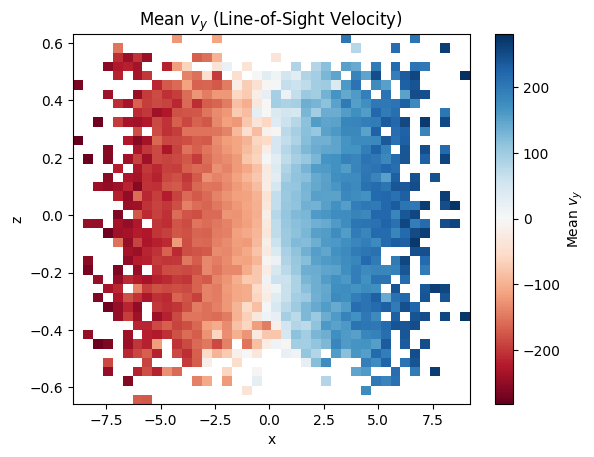

In [8]:
# Plot with imshow
plt.imshow(mean_vy.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
           cmap='RdBu')#, vmin = np.percentile(mean_vy, 0.001), vmax = np.percentile(mean_vy, 99.999))
plt.xlabel('x')
plt.ylabel('z')
plt.title('Mean $v_y$ (Line-of-Sight Velocity)')
plt.colorbar(label='Mean $v_y$')
#plt.axis('equal')
plt.show()

In [ ]:
import jax
import jax.numpy as jnp

def _soft_hist2d_mean_fast(x, z, vy, x_edges, z_edges, sigma_x, sigma_z):
    cx = 0.5 * (x_edges[:-1] + x_edges[1:])  # [Nx]
    cz = 0.5 * (z_edges[:-1] + z_edges[1:])  # [Nz]

    dx = (cx[:, None] - x[None, :]) / sigma_x      # [Nx, Np]
    dz = (cz[:, None] - z[None, :]) / sigma_z      # [Nz, Np]

    wx = jnp.exp(-0.5 * dx**2)                     # [Nx, Np]
    wz = jnp.exp(-0.5 * dz**2)                     # [Nz, Np]

    # zwei Matrixmultiplikationen statt 3D-Tensor:
    # vy_sum[i,j] = sum_k wx[i,k] * wz[j,k] * vy[k]
    vy_sum = (wx * vy[None, :]) @ wz.T             # [Nx, Nz]
    counts = wx @ wz.T                              # [Nx, Nz]

    return vy_sum / (counts + 1e-12)

def forward_model_map_soft(key, params, n_candidates, envelope_max,
                      num_bins_x=40, num_bins_z=40, sigma_frac=0.5):
    samples, soft_weights = sample_df_potential(key, params, n_candidates, envelope_max, tau=0.01)
    phase = map_actions_to_phase_space(samples, params, key)
    x, y, z, v_x, v_y, v_z = (phase[:, k] for k in range(6))

    x_min, x_max = jnp.min(x), jnp.max(x)
    z_min, z_max = jnp.min(z), jnp.max(z)
    x_edges = jnp.linspace(x_min, x_max, num_bins_x + 1)
    z_edges = jnp.linspace(z_min, z_max, num_bins_z + 1)

    bw_x = (x_max - x_min) / num_bins_x
    bw_z = (z_max - z_min) / num_bins_z
    sigma_x = jnp.maximum(sigma_frac * bw_x, 1e-8)
    sigma_z = jnp.maximum(sigma_frac * bw_z, 1e-8)

    mean_vy = _soft_hist2d_mean_fast(x, z, v_y, x_edges, z_edges, sigma_x, sigma_z)
    return x_edges, z_edges, mean_vy


In [10]:
x, y, mean_vy = forward_model_map_soft(key, params, n_candidates, envelope_max)

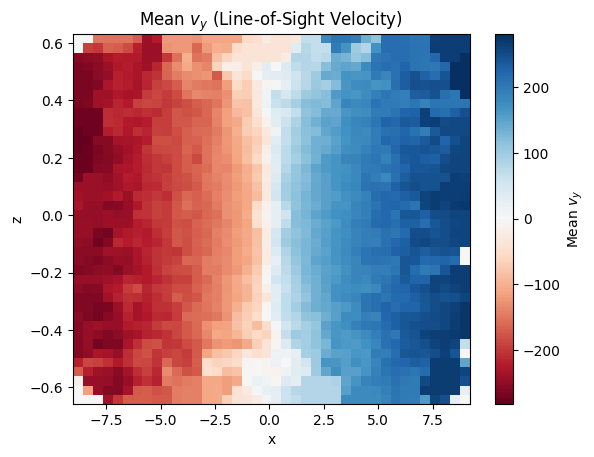

In [11]:
# Plot with imshow
plt.imshow(mean_vy.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
           cmap='RdBu')#, vmin = np.percentile(mean_vy, 0.001), vmax = np.percentile(mean_vy, 99.999))
plt.xlabel('x')
plt.ylabel('z')
plt.title('Mean $v_y$ (Line-of-Sight Velocity)')
plt.colorbar(label='Mean $v_y$')
#plt.axis('equal')
plt.show()

In [13]:
from functools import partial

# Wrap to leave only 'params' as the differentiable argument.
def _mean_vy_only(params):
    _, _, mean_vy = forward_model_map_soft(key, params, n_candidates, envelope_max)
    return jnp.mean(mean_vy)

# Full Jacobian: for each leaf in params -> array with shape [Nx, Nz, *leaf_shape]
#jac_fn = jax.jacobian(_mean_vy_only)
#jacobian = jac_fn(params)


In [14]:
from functools import partial

# Wrap to leave only 'params' as the differentiable argument.
def _mean_vy_only(params):
    _, _, mean_vy = forward_model_map_soft(key, params, n_candidates, envelope_max)
    return jnp.nanmean(mean_vy)

# Full Jacobian: for each leaf in params -> array with shape [Nx, Nz, *leaf_shape]
_mean_vy_only_jit = jax.jit(_mean_vy_only, static_argnums=())
grad_fn = jax.jit(jax.grad(_mean_vy_only_jit))
gradient = grad_fn(params)
jax.block_until_ready(gradient)


{'L0': Array(nan, dtype=float32, weak_type=True),
 'L0_thick': Array(nan, dtype=float32, weak_type=True),
 'R0': Array(nan, dtype=float32, weak_type=True),
 'Rd': Array(nan, dtype=float32, weak_type=True),
 'Rd_thick': Array(nan, dtype=float32, weak_type=True),
 'Z_max': Array(0., dtype=float32, weak_type=True),
 'Z_min': Array(0., dtype=float32, weak_type=True),
 'beta': Array(nan, dtype=float32, weak_type=True),
 'frac_thick': Array(nan, dtype=float32, weak_type=True),
 'sigma_r0': Array(nan, dtype=float32, weak_type=True),
 'sigma_r0_thick': Array(nan, dtype=float32, weak_type=True),
 'sigma_z0': Array(nan, dtype=float32, weak_type=True),
 'sigma_z0_thick': Array(nan, dtype=float32, weak_type=True),
 't0': Array(nan, dtype=float32, weak_type=True),
 'tau1': Array(nan, dtype=float32, weak_type=True),
 'tau_m': Array(nan, dtype=float32, weak_type=True)}

In [15]:
print(gradient)

{'L0': Array(nan, dtype=float32, weak_type=True), 'L0_thick': Array(nan, dtype=float32, weak_type=True), 'R0': Array(nan, dtype=float32, weak_type=True), 'Rd': Array(nan, dtype=float32, weak_type=True), 'Rd_thick': Array(nan, dtype=float32, weak_type=True), 'Z_max': Array(0., dtype=float32, weak_type=True), 'Z_min': Array(0., dtype=float32, weak_type=True), 'beta': Array(nan, dtype=float32, weak_type=True), 'frac_thick': Array(nan, dtype=float32, weak_type=True), 'sigma_r0': Array(nan, dtype=float32, weak_type=True), 'sigma_r0_thick': Array(nan, dtype=float32, weak_type=True), 'sigma_z0': Array(nan, dtype=float32, weak_type=True), 'sigma_z0_thick': Array(nan, dtype=float32, weak_type=True), 't0': Array(nan, dtype=float32, weak_type=True), 'tau1': Array(nan, dtype=float32, weak_type=True), 'tau_m': Array(nan, dtype=float32, weak_type=True)}
